In [10]:
import pandas as pd 
import numpy as np
import numpy as np 
import pickle
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

import spacy
import re
import nltk, string
from nltk.corpus import stopwords
from textblob import TextBlob, Word

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import hstack, vstack
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.model_selection import learning_curve, StratifiedShuffleSplit, StratifiedKFold, ShuffleSplit

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score, accuracy_score, f1_score

from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding
from keras import preprocessing
import numpy as np
from sklearn.model_selection import train_test_split
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.preprocessing import sequence
from keras.layers import Embedding, SimpleRNN
import datetime

#load stopwords corpus
import nltk
nltk.download('stopwords')
#load the en_core_web_sm 
import en_core_web_sm
nlp = en_core_web_sm.load()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yuzhu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
CBS_NEWS=pd.read_csv(r"C:\Users\yuzhu\Documents\725_2semester\cbs_news_content.csv",header=None)
CBS_NEWS.columns=['link',"title","Author","timestamp","Paragraph_num","Paragraph_text","download_date"]
CBS_NEWS

,link,title,Author,timestamp,Paragraph_num,Paragraph_text,download_date
0,https://www.cbsnews.com/news/antares-rocket-bo...,Northrop Grumman Antares rocket boosts space s...,WILLIAM HARWOOD,2020-02-15 16:26:00,0,"Running nearly a week late, a Northrop Grumman...",2020-02-17 21:19:12
1,https://www.cbsnews.com/news/antares-rocket-bo...,Northrop Grumman Antares rocket boosts space s...,WILLIAM HARWOOD,2020-02-15 16:26:00,1,The rocket's Russian-built RD-181 first stage ...,2020-02-17 21:19:12
2,https://www.cbsnews.com/news/antares-rocket-bo...,Northrop Grumman Antares rocket boosts space s...,WILLIAM HARWOOD,2020-02-15 16:26:00,2,Climbing away to the southeast directly into t...,2020-02-17 21:19:12
3,https://www.cbsnews.com/news/antares-rocket-bo...,Northrop Grumman Antares rocket boosts space s...,WILLIAM HARWOOD,2020-02-15 16:26:00,3,The launch came six days after a last-minute a...,2020-02-17 21:19:12
4,https://www.cbsnews.com/news/antares-rocket-bo...,Northrop Grumman Antares rocket boosts space s...,WILLIAM HARWOOD,2020-02-15 16:26:00,4,"Once off the pad, the climb to orbit went smoo...",2020-02-17 21:19:12
...,...,...,...,...,...,...,...
9434,https://www.cbsnews.com/news/the-retro-future-...,"The ""retro-future"" of ""The Jetsons""",NaN,2013-04-29 20:58:00,20,"After all, gadgets are still only as good as t...",2020-02-18 12:46:58
9435,https://www.cbsnews.com/news/the-retro-future-...,"The ""retro-future"" of ""The Jetsons""",NaN,2013-04-29 20:58:00,21,"""There's still so many elements of the 'Jetson...",2020-02-18 12:46:58
9436,https://www.cbsnews.com/news/the-retro-future-...,"The ""retro-future"" of ""The Jetsons""",NaN,2013-04-29 20:58:00,22,"""We might get our flying cars yet,"" said Cowan.",2020-02-18 12:46:58
9437,https://www.cbsnews.com/news/the-retro-future-...,"The ""retro-future"" of ""The Jetsons""",NaN,2013-04-29 20:58:00,23,"""Exactly!""",2020-02-18 12:46:58


In [4]:
#create a stop words list
stopWordList = [word for word in list(stopwords.words('english') ) if word not in ['no', 'not']]
# all the data in this dataset is true news, then the target show all equal to 0
CBS_NEWS["target"]=0
stopWordList

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [5]:
# list of punctuation that need to be removed
punct_removal = list(string.punctuation) + ["--", "---"]
# define the the word pattern
word_pattern = r"(?u)\b\w\w+\b"
punct_removal

['!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~',
 '--',
 '---']

In [7]:
#check if NAN in columns
CBS_NEWS["Paragraph_text"].isnull().values.any()

#check how many of NAN in columns
CBS_NEWS["Paragraph_text"].isnull().sum()
# check how many NAN in the whole dataset
CBS_NEWS.isnull().values.sum()

# fill the NAN with whitespace
CBS_NEWS["Paragraph_text"]=CBS_NEWS["Paragraph_text"].fillna(" ")

In [8]:
print(datetime.datetime.today())
tokened_para=[]
for i in range(len(CBS_NEWS)):
    word_pat = re.compile(word_pattern, flags = re.UNICODE )

    CBS_NEWS["Paragraph_text"][i] = " ".join(word_pat.findall(CBS_NEWS["Paragraph_text"][i])).lower()
    
    tokens = nlp(CBS_NEWS["Paragraph_text"][i])
    #lemmatising tokens 
    tokens = [t.lemma_.strip() if t.lemma_ != "-PRON-" else t.lower_ for t in tokens]
    #stopword and punctuation removal
    tokens = [t for t in tokens if (t not in stopWordList and t not in punct_removal)]
    processed_text = " ".join(tokens)
    tokened_para.append(processed_text) 
tokened_para
print(datetime.datetime.today())

C:\Users\yuzhu\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Wall time: 4min 8s


['run nearly week late northrop grumman antares rocket finally thunder away virginia eastern shore saturday lift cygnus cargo ship orbit three day flight international space station',
 'rocket russian build rd 181 first stage engine flash life 21 e throttle jet brilliant exhaust second later final round computer check rocket release pad 0a mid atlantic regional spaceport mars nasa wallops island virginia facility',
 'climb away southeast directly plane space station orbit upgraded antare 230 rapidly accelerate consume propellant lose weight disappear view partly cloudy sky',
 'launch come six day last minute abort last sunday due problem ground support equipment mission manager opt reschedule friday make repair wait bad weather replace time sensitive science sample station bind cygnus cargo dangerous upper level wind trigger another delay push launch saturday',
 'pad climb orbit go smoothly supply ship release fly nine minute liftoff go well cygnus reach space station early tuesday pul

In [12]:
print(datetime.datetime.today())
tokened_title=[]
for i in range(len(CBS_NEWS)):
    word_pat = re.compile(word_pattern, flags = re.UNICODE )
    CBS_NEWS["title"][i] = " ".join(word_pat.findall(CBS_NEWS["title"][i])).lower()
    tokens = nlp(CBS_NEWS["title"][i])
    #lemmatising tokens 
    tokens = [t.lemma_.strip() if t.lemma_ != "-PRON-" else t.lower_ for t in tokens]
    #stopword and punctuation removal
    tokens = [t for t in tokens if (t not in stopWordList and t not in punct_removal)]
    processed_text = " ".join(tokens)
    tokened_title.append(processed_text) 
print(datetime.datetime.today())
tokened_title

2021-03-14 13:57:12.560858


C:\Users\yuzhu\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


2021-03-14 13:59:45.035892


['northrop grumman antares rocket boost space station cargo ship orbit',
 'northrop grumman antares rocket boost space station cargo ship orbit',
 'northrop grumman antares rocket boost space station cargo ship orbit',
 'northrop grumman antares rocket boost space station cargo ship orbit',
 'northrop grumman antares rocket boost space station cargo ship orbit',
 'northrop grumman antares rocket boost space station cargo ship orbit',
 'northrop grumman antares rocket boost space station cargo ship orbit',
 'northrop grumman antares rocket boost space station cargo ship orbit',
 'northrop grumman antares rocket boost space station cargo ship orbit',
 'northrop grumman antares rocket boost space station cargo ship orbit',
 'northrop grumman antares rocket boost space station cargo ship orbit',
 'northrop grumman antares rocket boost space station cargo ship orbit',
 'northrop grumman antares rocket boost space station cargo ship orbit',
 'northrop grumman antares rocket boost space stati

In [13]:
tokened_para_df=pd.DataFrame(tokened_para)
tokened_title_df=pd.DataFrame(tokened_title)
CBS_NEWS["tokened_para"]=tokened_para_df
CBS_NEWS["tokened_title"]=tokened_title_df
CBS_NEWS['all_text']=CBS_NEWS["tokened_title"]+CBS_NEWS["tokened_para"]

In [14]:
# CBS_NEWS[["tokened_title","tokened_para","target"]]
CBS_NEWS["tokened_para"]

0       run nearly week late northrop grumman antares ...
1       rocket russian build rd 181 first stage engine...
2       climb away southeast directly plane space stat...
3       launch come six day last minute abort last sun...
4       pad climb orbit go smoothly supply ship releas...
                              ...                        
9434          gadget still good people use even year 2062
9435    still many element jetson future people consta...
9436                        may get fly car yet say cowan
9437                                              exactly
9438                                                 info
Name: tokened_para, Length: 9439, dtype: object

In [15]:
PEPPER_NEWS=pd.read_csv(r"C:\Users\yuzhu\Documents\725_2semester\pepper_news_content.csv",header=None)

In [16]:
PEPPER_NEWS.columns=PEPPER_NEWS.loc[0,]
PEPPER_NEWS=PEPPER_NEWS.loc[1:,]

In [13]:
PEPPER_NEWS.columns

Index(['title', 'author', 'time_stamp', 'paragraph_num', 'paragragh'], dtype='object', name=0)

In [17]:
PEPPER_NEWS["Paragraph_text"]=PEPPER_NEWS[ 'paragragh'].fillna(" ")
PEPPER_NEWS["title"]=PEPPER_NEWS[ 'title'].fillna(" ")

In [18]:
%%time
tokened_para_p=[]
for i in range(1,len(PEPPER_NEWS)):
    word_pat = re.compile(word_pattern, flags = re.UNICODE )

    PEPPER_NEWS["Paragraph_text"][i] = " ".join(word_pat.findall(PEPPER_NEWS["Paragraph_text"][i])).lower()
    
    tokens = nlp(PEPPER_NEWS["Paragraph_text"][i])
    #lemmatising tokens 
    tokens = [t.lemma_.strip() if t.lemma_ != "-PRON-" else t.lower_ for t in tokens]
    #stopword and punctuation removal
    tokens = [t for t in tokens if (t not in stopWordList and t not in punct_removal)]
    processed_text = " ".join(tokens)
    tokened_para_p.append(processed_text) 

Wall time: 34.1 s


In [19]:
%%time
tokened_title_p=[]
for i in range(1,len(PEPPER_NEWS)):
    word_pat = re.compile(word_pattern, flags = re.UNICODE )
    PEPPER_NEWS["title"][i] = " ".join(word_pat.findall(PEPPER_NEWS["title"][i])).lower()
    tokens = nlp(PEPPER_NEWS["title"][i])
    #lemmatising tokens 
    tokens = [t.lemma_.strip() if t.lemma_ != "-PRON-" else t.lower_ for t in tokens]
    #stopword and punctuation removal
    tokens = [t for t in tokens if (t not in stopWordList and t not in punct_removal)]
    processed_text = " ".join(tokens)
    tokened_title_p.append(processed_text) 

Wall time: 22.1 s


In [20]:
tokened_para_p_df=pd.DataFrame(tokened_para_p)
tokened_title_p_df=pd.DataFrame(tokened_title_p)
PEPPER_NEWS["tokened_para"]=tokened_para_p_df
PEPPER_NEWS["tokened_title"]=tokened_title_p_df
PEPPER_NEWS['all_text']=PEPPER_NEWS["tokened_title"]+PEPPER_NEWS["tokened_para"]

In [21]:
PEPPER_NEWS['target']=1
PEPPER_NEWS=PEPPER_NEWS.rename(columns={"author":"Author"})
PEPPER_NEWS.columns

Index(['title', 'Author', 'time_stamp', 'paragraph_num', 'paragragh',
       'Paragraph_text', 'tokened_para', 'tokened_title', 'all_text',
       'target'],
      dtype='object', name=0)

In [22]:
CBS_NEWS=CBS_NEWS[['title', 'Author', 'tokened_para','tokened_title', 'all_text','target']]

In [23]:
PEPPER_NEWS=PEPPER_NEWS[['title', 'Author', 'tokened_para','tokened_title', 'all_text','target']]

In [24]:
NEWS_COMBINE=pd.concat([CBS_NEWS,PEPPER_NEWS],axis=0)
NEWS_COMBINE=NEWS_COMBINE.dropna(subset=['tokened_title', 'tokened_para'])

In [25]:
NEWS_COMBINE.shape

(10949, 6)

In [25]:
NEWS_COMBINE.groupby("target").count()

,title,Author,tokened_para,tokened_title,all_text
target,,,,,
0,9439,5954,9439,9439,9439
1,1510,1510,1510,1510,1510


In [27]:
NEWS_COMBINE

,title,Author,tokened_para,tokened_title,all_text,target
0,northrop grumman antares rocket boosts space s...,WILLIAM HARWOOD,run nearly week late northrop grumman antares ...,northrop grumman antares rocket boost space st...,northrop grumman antares rocket boost space st...,0
1,northrop grumman antares rocket boosts space s...,WILLIAM HARWOOD,rocket russian build rd 181 first stage engine...,northrop grumman antares rocket boost space st...,northrop grumman antares rocket boost space st...,0
2,northrop grumman antares rocket boosts space s...,WILLIAM HARWOOD,climb away southeast directly plane space stat...,northrop grumman antares rocket boost space st...,northrop grumman antares rocket boost space st...,0
3,northrop grumman antares rocket boosts space s...,WILLIAM HARWOOD,launch come six day last minute abort last sun...,northrop grumman antares rocket boost space st...,northrop grumman antares rocket boost space st...,0
4,northrop grumman antares rocket boosts space s...,WILLIAM HARWOOD,pad climb orbit go smoothly supply ship releas...,northrop grumman antares rocket boost space st...,northrop grumman antares rocket boost space st...,0
...,...,...,...,...,...,...
1506,breaking news legislation passed allowing man ...,Peter (Spiceworks),completely ignore comment ceo go know amazing ...,break news legislation pass allow man computer...,break news legislation pass allow man computer...,1
1507,breaking news legislation passed allowing man ...,Peter (Spiceworks),suddenly deafen crack sound reverberate office...,break news legislation pass allow man computer...,break news legislation pass allow man computer...,1
1508,breaking news legislation passed allowing man ...,Peter (Spiceworks),fall flail slow motion ground mr barry smartph...,break news legislation pass allow man computer...,break news legislation pass allow man computer...,1
1509,breaking news legislation passed allowing man ...,Peter (Spiceworks),always one last laugh director tom could barel...,break news legislation pass allow man computer...,break news legislation pass allow man computer...,1


In [28]:
%%time
vec = TfidfVectorizer(ngram_range=(1,3))
vec.fit(NEWS_COMBINE.all_text)
vocab = vec.vocabulary_
    
# vecH = TfidfVectorizer(ngram_range=(1,3), max_df=0.8, vocabulary=vocab)
# vecH.fit(NEWS_COMBINE.tokened_title.unique())
    
vecB = TfidfVectorizer(ngram_range=(1,3), max_df=0.8, vocabulary=vocab)
vecB.fit(NEWS_COMBINE.tokened_para.unique())
    
# xHTrainTfidf = vecH.transform(NEWS_COMBINE.tokened_title)
# print ('Train headline matrix shape: \t', xHTrainTfidf.shape)
    
xBTrainTfidf = vecB.transform(NEWS_COMBINE.tokened_para)
print('Train body matrix shape: \t', xBTrainTfidf.shape) 

Train body matrix shape: 	 (10949, 417398)
Wall time: 8.83 s


In [38]:
xBTrainTfidf.shape

(10949, 417398)

In [32]:
from keras.preprocessing.text import Tokenizer

In [164]:
# from keras.preprocessing.text import Tokenizer
# # We create a tokenizer, configured to only take
# # into account the top-1000 most common words
# tokenizer = Tokenizer()
# # This builds the word index
# tokenizer.fit_on_texts(NEWS_COMBINE['tokened_para'])

# # This turns strings into lists of integer indices.
# sequences = tokenizer.texts_to_sequences(NEWS_COMBINE['tokened_para'])

# # You could also directly get the one-hot binary representations.
# # Note that other vectorization modes than one-hot encoding are supported!
# one_hot_results = tokenizer.texts_to_matrix(NEWS_COMBINE['tokened_para'], mode='binary')

# # This is how you can recover the word index that was computed
# word_index = tokenizer.word_index
# print('Found %s unique tokens.' % len(word_index))

Found 14920 unique tokens.


In [33]:
from keras.datasets import imdb
from keras.preprocessing import sequence

# max_features = 10000  # number of words to consider as features
# maxlen = 500  # cut texts after this number of words (among top max_features most common words)
# batch_size = 32

# print('Loading data...')
# (input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
# print(len(input_train), 'train sequences')
# print(len(input_test), 'test sequences')

# print('Pad sequences (samples x time)')
# input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
# input_test = sequence.pad_sequences(input_test, maxlen=maxlen)


In [34]:
from keras.layers import Embedding
from keras import preprocessing
import numpy as np
from sklearn.model_selection import train_test_split
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.preprocessing import sequence
from keras.layers import Embedding, SimpleRNN


from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 3)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 3)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 3)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 3)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

X_train, X_test, y_train, y_test = train_test_split(NEWS_COMBINE["tokened_para"],NEWS_COMBINE.iloc[:,-1],test_size=0.2,random_state=42)


In [35]:
# from the Tfid the max_feature is xBTrainTfidf.shape
max_feature=xBTrainTfidf.shape[1]
# max_feature=10000
# select the top 500 in the sequence
maxlen=500

tk = Tokenizer()
tk.fit_on_texts(X_train)
tk.fit_on_texts(X_test)
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=maxlen)
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=maxlen)

In [36]:
max_feature

417398

In [152]:
X_train_seq_trunc.shape

(8759, 500)

In [153]:
X_test_seq_trunc.shape

(2190, 500)

In [127]:
model_Simple = Sequential()
model_Simple.add(layers.Embedding(max_feature, 8, input_length=maxlen))
model_Simple.add(SimpleRNN(32))
model_Simple.add(Dense(1, activation='sigmoid'))

model_Simple.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])
history = model_Simple.fit(X_train_seq_trunc, y_train,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.2)

C:\Users\yuzhu\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 6131 samples, validate on 1533 samples
Epoch 1/15
6131/6131 [==============================] - 13s 2ms/step - loss: 0.3864 - acc: 0.8553 - f1_m: 0.0032 - precision_m: 0.0045 - recall_m: 0.0025 - val_loss: 0.2735 - val_acc: 0.8663 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/15
6131/6131 [==============================] - 13s 2ms/step - loss: 0.3753 - acc: 0.8292 - f1_m: 0.5029 - precision_m: 0.6630 - recall_m: 0.5380 - val_loss: 0.1945 - val_acc: 0.9817 - val_f1_m: 0.9239 - val_precision_m: 1.0000 - val_recall_m: 0.8616
Epoch 3/15
6131/6131 [==============================] - 13s 2ms/step - loss: 0.1320 - acc: 0.9876 - f1_m: 0.9521 - precision_m: 1.0000 - recall_m: 0.9122 - val_loss: 0.0880 - val_acc: 0.9902 - val_f1_m: 0.9626 - val_precision_m: 1.0000 - val_recall_m: 0.9299
Epoch 4/15
6131/6131 [==============================] - 13s 2ms/step - loss: 0.0540 - acc: 0.9928 - f1_m: 0.9771 - precision_m: 0.9936 - recall_m: 0.9634 - val_los

In [128]:
loss, accuracy, f1_score, precision, recall = model_Simple.evaluate(X_test_seq_trunc, y_test, verbose=0)
print("the Accuracy for SimpleRNN is "+ str(accuracy*100)+"%")
print("the f1_score for SimpleRNN is "+ str(f1_score))
print("the precision for SimpleRNN is "+ str(precision))
print("the recall for SimpleRNN is "+ str(recall))

the Accuracy for SimpleRNN is 100.0%
the f1_score for SimpleRNN is 1.0
the precision for SimpleRNN is 1.0
the recall for SimpleRNN is 1.0


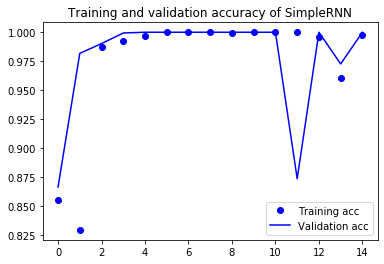

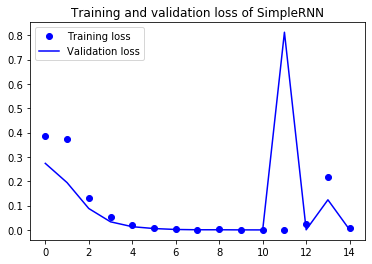

In [129]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy of SimpleRNN')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss of SimpleRNN')
plt.legend()

plt.show()

In [120]:
# %%time
# from keras import models
# from keras import layers
# model_Flatten = models.Sequential()
# model_Flatten.add(layers.Embedding(max_feature, 8, input_length=maxlen))
# model_Flatten.add(layers.Flatten())
# model_Flatten.add(Dense(1, activation='sigmoid'))

# model_Flatten.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])
# history = model_Flatten.fit(X_train_seq_trunc, y_train,
#                     epochs=30,
#                     batch_size=128,
#                     validation_split=0.2)

In [121]:
# model_Flatten.evaluate(X_test_seq_trunc,y_test)

In [122]:
# import matplotlib.pyplot as plt

# acc = history.history['acc']
# val_acc = history.history['val_acc']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs = range(len(acc))

# plt.plot(epochs, acc, 'bo', label='Training acc')
# plt.plot(epochs, val_acc, 'b', label='Validation acc')
# plt.title('Training and validation accuracy of Flatten')
# plt.legend()

# plt.figure()

# plt.plot(epochs, loss, 'bo', label='Training loss')
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
# plt.title('Training and validation loss of Flatten')
# plt.legend()

# plt.show()

In [154]:
%%time
#optimizer is RMSprop
from keras.layers import LSTM
from keras import models
from keras import layers
model_LSTM = models.Sequential()
model_LSTM.add(layers.Embedding(max_feature, 8, input_length=maxlen))
model_LSTM.add(layers.LSTM(32))
model_LSTM.add(Dense(1, activation='sigmoid'))

model_LSTM.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])
history = model_LSTM.fit(X_train_seq_trunc, y_train,
                    epochs=15,
                    batch_size=128,
                    validation_split=0.2)


C:\Users\yuzhu\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 7007 samples, validate on 1752 samples
Epoch 1/15
7007/7007 [==============================] - 70s 10ms/step - loss: 0.3693 - acc: 0.8556 - f1_m: 0.0233 - precision_m: 0.0759 - recall_m: 0.0235 - val_loss: 0.1709 - val_acc: 0.9292 - val_f1_m: 0.6299 - val_precision_m: 1.0000 - val_recall_m: 0.4683
Epoch 2/15
7007/7007 [==============================] - 62s 9ms/step - loss: 0.1936 - acc: 0.9578 - f1_m: 0.7669 - precision_m: 0.8909 - recall_m: 0.7000 - val_loss: 0.0652 - val_acc: 0.9909 - val_f1_m: 0.9651 - val_precision_m: 1.0000 - val_recall_m: 0.9350
Epoch 3/15
7007/7007 [==============================] - 73s 10ms/step - loss: 0.0570 - acc: 0.9933 - f1_m: 0.9723 - precision_m: 1.0000 - recall_m: 0.9551 - val_loss: 0.0325 - val_acc: 0.9994 - val_f1_m: 0.9975 - val_precision_m: 0.9952 - val_recall_m: 1.0000
Epoch 4/15
7007/7007 [==============================] - 81s 11ms/step - loss: 0.0225 - acc: 0.9991 - f1_m: 0.9974 - precision_m: 1.0000 - recall_m: 0.9949 - val_loss: 0.0141

In [155]:
# model_LSTM.evaluate(X_test_seq_trunc,y_test)
loss, accuracy, f1_score, precision, recall = model_LSTM.evaluate(X_test_seq_trunc, y_test, verbose=0)
print("the Accuracy for LSTM is {0} ".format(accuracy))
print("the f1_score for LSTM is {0}  ".format(f1_score))
print("the precision for LSTM is {0} ".format(precision))
print("the recall for LSTM is {0} ".format(recall))

the Accuracy for LSTM is 1.0 
the f1_score for LSTM is 1.0  
the precision for LSTM is 1.0 
the recall for LSTM is 1.0 


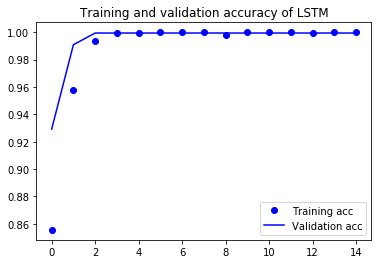

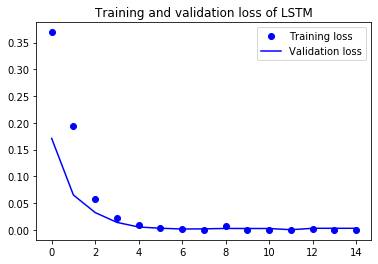

In [156]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy of LSTM')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss of LSTM')
plt.legend()

plt.show()

In [133]:
# %%time
# #optimizer is Adam
# from keras.layers import LSTM
# from keras import models
# from keras import layers
# model_ADM_LSTM = models.Sequential()
# model_ADM_LSTM.add(layers.Embedding(max_feature, 8, input_length=maxlen))
# model_ADM_LSTM.add(layers.LSTM(32))
# model_ADM_LSTM.add(Dense(1, activation='sigmoid'))

# model_ADM_LSTM.compile(optimizer='adam', loss='binary_crossentropy',metrics=['acc',f1_m,precision_m, recall_m])
# history = model_ADM_LSTM.fit(X_train_seq_trunc, y_train,
#                     epochs=30,
#                     batch_size=128,
#                     validation_split=0.2)

In [71]:
# model_ADM_LSTM.evaluate(X_test_seq_trunc,y_test)
# # model_LSTM.evaluate(X_test_seq_trunc,y_test)
# loss, accuracy, f1_score, precision, recall = model_ADM_LSTM.evaluate(X_test_seq_trunc, y_test, verbose=0)
# print("the Accuracy for Adm LSTM is "+ str(accuracy*100)+"%")
# print("the f1_score for Adm LSTM is "+ str(f1_score))
# print("the precision for Adm LSTM is "+ str(precision))
# print("the recall for Adm LSTM is "+ str(recall))

3614/3614 [==============================] - 15s 4ms/step


[0.0008254901962100946, 1.0]

In [134]:
# acc = history.history['acc']
# val_acc = history.history['val_acc']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs = range(len(acc))

# plt.plot(epochs, acc, 'bo', label='Training acc')
# plt.plot(epochs, val_acc, 'b', label='Validation acc')
# plt.title('Training and validation accuracy of Adam LSTM')
# plt.legend()

# plt.figure()

# plt.plot(epochs, loss, 'bo', label='Training loss')
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
# plt.title('Training and validation loss of Adam LSTM')
# plt.legend()

# plt.show()

In [135]:
%%time
#optimizer is Adam
from keras.layers import LSTM
from keras import models
from keras import layers
model_BiD_LSTM = models.Sequential()
model_BiD_LSTM.add(layers.Embedding(max_feature, 8, input_length=maxlen))
model_BiD_LSTM.add(layers.Bidirectional(layers.LSTM(32)))
model_BiD_LSTM.add(Dense(1, activation='sigmoid'))

model_BiD_LSTM.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['acc',f1_m,precision_m, recall_m])
history = model_BiD_LSTM.fit(X_train_seq_trunc, y_train,
                    epochs=15,
                    batch_size=128,
                    validation_split=0.2)

C:\Users\yuzhu\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 6131 samples, validate on 1533 samples
Epoch 1/15
6131/6131 [==============================] - 90s 15ms/step - loss: 0.4987 - acc: 0.8444 - f1_m: 0.0048 - precision_m: 0.0028 - recall_m: 0.0154 - val_loss: 0.3687 - val_acc: 0.8663 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/15
6131/6131 [==============================] - 117s 19ms/step - loss: 0.2646 - acc: 0.8733 - f1_m: 0.1424 - precision_m: 0.2083 - recall_m: 0.1157 - val_loss: 0.1169 - val_acc: 0.9733 - val_f1_m: 0.8827 - val_precision_m: 1.0000 - val_recall_m: 0.7950
Epoch 3/15
6131/6131 [==============================] - 143s 23ms/step - loss: 0.0901 - acc: 0.9931 - f1_m: 0.9752 - precision_m: 0.9988 - recall_m: 0.9562 - val_loss: 0.0609 - val_acc: 1.0000 - val_f1_m: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 4/15
6131/6131 [==============================] - 85s 14ms/step - loss: 0.0477 - acc: 0.9998 - f1_m: 0.9994 - precision_m: 1.0000 - recall_m: 0.9988 - v

In [139]:
loss, accuracy, f1_score, precision, recall = model_BiD_LSTM.evaluate(X_test_seq_trunc, y_test, verbose=0)
print("the Accuracy for BiDirection LSTM is "+ str(round(accuracy*100,3)+"%"))
print("the f1_score for BiDirection LSTM is "+ str(round(f1_score,3)))
print("the precision for BiDirection LSTM is "+ str(round(precision,3)))
print("the recall for BiDirection LSTM is "+ str(round(recall,3)))

TypeError: unsupported operand type(s) for +: 'float' and 'str'

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy of Bidirectional Adam LSTM')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss of Bidirectional Adam LSTM')
plt.legend()

plt.show()

In [105]:
# y_test.asnumpy()

# y_test1=np.array(list(y_test))
# y_test1=np.float32(y_test1)
# y_pred1=np.array(list(y_pred))
# y_pred1=np.float32(y_pred1)